In [12]:
import pandas as pd
import pysentiment as ps
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

In [13]:
tweets = pd.read_excel('C:/Users/marga/Desktop/git/example_data.xlsx'
                    , parse_dates=['date'])
tweets.head(2)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1348731900492353536,1348730117413957632,2021-01-11 23:41:57 Russia TZ 2 Standard Time,2021-01-11,23:41:57,300,794047025624952832,jakeypoohlv,🏳️‍🌈🌹Jake Galardi Marko🌹🏳️‍🌈,NaN,...,"39.833333,-98.583333,1800km",NaN,NaN,NaN,NaN,"[{'screen_name': 'OurRevolutionNV', 'name': 'O...",NaN,NaN,NaN,NaN
1,1348669317538217984,1348669317538217984,2021-01-11 19:33:17 Russia TZ 2 Standard Time,2021-01-11,19:33:17,300,1114970489942753280,buddjenn,Jenn Budd,NaN,...,"39.833333,-98.583333,1800km",NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [14]:
#Data cleaning

def text_only(x):
    return re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", x)

tweets = pd.DataFrame(tweets, columns = ['date', 'tweet','retweets_count'])
tweets['tweet'] = tweets['tweet'].apply(text_only)
tweets['tweet'].head(3)

0     Nealry 400k Americans have died &amp; 16 mill...
1    I find it bizarre that anyone thinks Trump may...
2    Maybe your followers died from  Perhaps your b...
Name: tweet, dtype: object

### Оценка тональности по словарю General Inquirer (Harvard IV-4 и Laswell)

In [15]:
t = pd.Series(tweets['tweet'])

hiv4 = ps.HIV4()
hscore = []
for i in t:
    #print(i)
    tokens = hiv4.tokenize(i)
    score = hiv4.get_score(tokens)
    hscore.append(score)

C:\Users\marga\anaconda31\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (63,108,109,110,176) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
df = pd.DataFrame(hscore)
harvard_lex = tweets.join(df, rsuffix='_right')
harvard_lex =pd.DataFrame(harvard_lex, columns = ['date', 'tweet','retweets_count','Positive','Negative', 'Polarity', 'Subjectivity'])
harvard_lex.head(3)

,date,tweet,retweets_count,Positive,Negative,Polarity,Subjectivity
0,2021-01-11,Nealry 400k Americans have died &amp; 16 mill...,13,3,3,0.000000,0.400000
1,2021-01-11,I find it bizarre that anyone thinks Trump may...,5,1,2,-0.333333,0.300000
2,2021-01-11,Maybe your followers died from Perhaps your b...,8,1,1,0.000000,0.333333


In [17]:
#Сохранение 
#harvard_lex.to_excel('results')

In [18]:
#избавляемся от нейтральных твитов
harvard_lex = harvard_lex[harvard_lex['Polarity'] !=0]

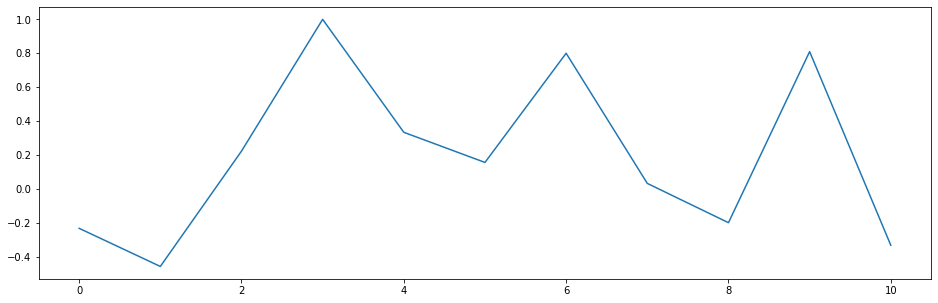

In [19]:
hv_day = harvard_lex.groupby(pd.Grouper(key="date", freq="D"))['Polarity'].mean().reset_index()
# Сохранение
#hv_day.to_excel('results_hv.xlsx')

figure(figsize=(16,5))
plt.plot(hv_day['Polarity'])

## Оценка тональности по словарю Loughran & McDonald

In [20]:
lm = ps.LM()
lmscore = []
for i in t:
    tokens = lm.tokenize(i)
    score = lm.get_score(tokens)
    lmscore.append(score)

In [21]:
df1 = pd.DataFrame(lmscore)
lm_lex = tweets.join(df1, rsuffix='_right')
lm_lex =pd.DataFrame(lm_lex, columns = ['date', 'tweet','retweets_count','Positive','Negative', 'Polarity', 'Subjectivity'])
lm_lex.to_excel('results_lm.xlsx')
lm_lex.head(3)

,date,tweet,retweets_count,Positive,Negative,Polarity,Subjectivity
0,2021-01-11,Nealry 400k Americans have died &amp; 16 mill...,13,1,2,-0.333333,0.200000
1,2021-01-11,I find it bizarre that anyone thinks Trump may...,5,0,0,0.000000,0.000000
2,2021-01-11,Maybe your followers died from Perhaps your b...,8,1,0,0.999999,0.166667


In [22]:
#избавляемся от нейтральных твитов
lm_lex = lm_lex[lm_lex['Polarity'] !=0]

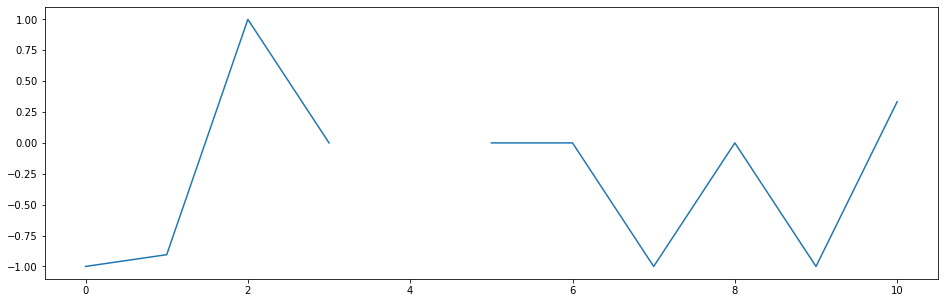

In [23]:
lm_day = lm_lex.groupby(pd.Grouper(key="date", freq="D"))['Polarity'].mean().reset_index()
#Сохранение
#lm_day.to_excel('results_lm_day.xlsx')

figure(figsize=(16,5))
plt.plot(lm_day['Polarity'])

## Оценка тональности по Vader

In [24]:
tweets.head(3)

,date,tweet,retweets_count
0,2021-01-11,Nealry 400k Americans have died &amp; 16 mill...,13
1,2021-01-11,I find it bizarre that anyone thinks Trump may...,5
2,2021-01-11,Maybe your followers died from Perhaps your b...,8


In [25]:
analyzer = SentimentIntensityAnalyzer()
scores = tweets['tweet'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores,columns = ['compound','neg', 'neu', 'pos'])
vader = tweets.join(df_scores, rsuffix='_right')
vader.head(3)

,date,tweet,retweets_count,compound,neg,neu,pos
0,2021-01-11,Nealry 400k Americans have died &amp; 16 mill...,13,-0.8950,0.252,0.748,0.000
1,2021-01-11,I find it bizarre that anyone thinks Trump may...,5,0.5719,0.081,0.707,0.212
2,2021-01-11,Maybe your followers died from Perhaps your b...,8,-0.1779,0.206,0.629,0.166


In [26]:
#Cохранение
#vader.to_excel('results_vader.xlsx')

In [27]:
#избавляемся от нейтральных твитов
vader = vader[vader['compound'] !=0]

In [28]:
dm_mean = vader.groupby(pd.Grouper(key="date", freq="D"))['compound'].mean().reset_index()
dm_mean = dm_mean.rename(columns = {'compound': 'dm'})

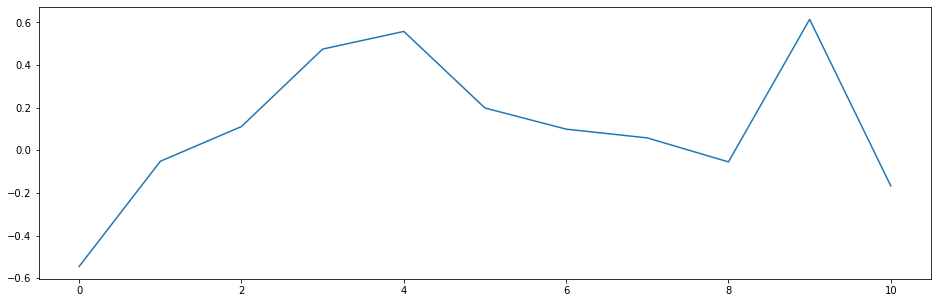

In [29]:
dm_mean.to_excel("results_vd_day.xlsx")

figure(figsize=(16,5))
plt.plot(dm_mean['dm'])


In [30]:
#по формуле    
formula1=(vader['pos']-vader['neg'])/(vader['pos']+vader['neg'])
formula2=(vader['pos']-vader['neg'])/(vader['pos']+vader['neg']+vader['neu'])

formula1 = pd.DataFrame(formula1, columns = ['formula1'])
formula2 = pd.DataFrame(formula2, columns = ['formula2'])

vader = vader.join(formula1,rsuffix='_right')
vader = vader.join(formula2,rsuffix='_right')
vader.head(3)

,date,tweet,retweets_count,compound,neg,neu,pos,formula1,formula2
0,2021-01-11,Nealry 400k Americans have died &amp; 16 mill...,13,-0.8950,0.252,0.748,0.000,-1.000000,-0.25200
1,2021-01-11,I find it bizarre that anyone thinks Trump may...,5,0.5719,0.081,0.707,0.212,0.447099,0.13100
2,2021-01-11,Maybe your followers died from Perhaps your b...,8,-0.1779,0.206,0.629,0.166,-0.107527,-0.03996


In [31]:
formula1_mean = vader.groupby(pd.Grouper(key="date", freq="D"))['formula1'].mean().reset_index()
formula2_mean = vader.groupby(pd.Grouper(key="date", freq="D"))['formula2'].mean().reset_index()

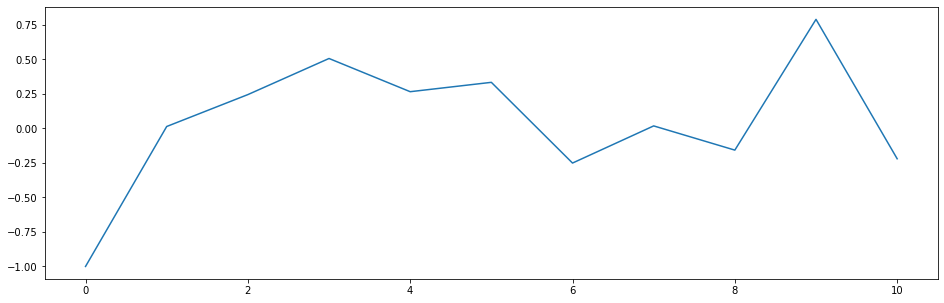

In [32]:
#formula1_mean.to_excel("results_vd_formula1.xlsx")

figure(figsize=(16,5))
plt.plot(formula1_mean['formula1'])

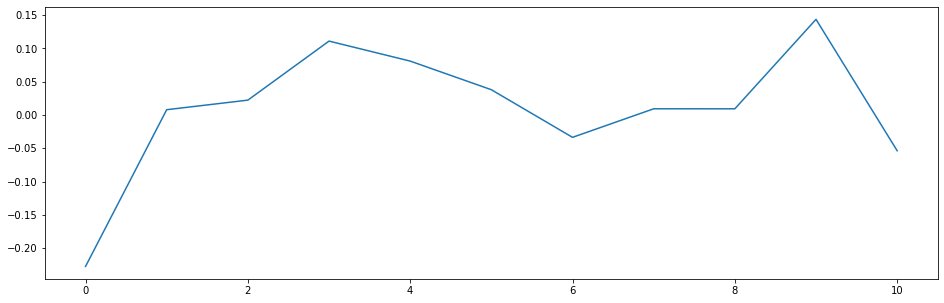

In [33]:
#formula2_mean.to_excel("results_vd_formula2.xlsx")

figure(figsize=(16,5))
plt.plot(formula2_mean['formula2'])

## Оценка тональности по Senticnet

In [34]:
from sentic import SenticPhrase

In [35]:
sscore = []
for i in t:
    #print(i)
    text = i
    sp = SenticPhrase(text)
    score = sp.get_polarity(text)
    sscore.append(score)

In [36]:
df3 = pd.DataFrame(sscore,columns = ['sentic'])
sentic = tweets.join(df3, rsuffix='_right')
sentic.head(3)

,date,tweet,retweets_count,sentic
0,2021-01-11,Nealry 400k Americans have died &amp; 16 mill...,13,0.236364
1,2021-01-11,I find it bizarre that anyone thinks Trump may...,5,0.126000
2,2021-01-11,Maybe your followers died from Perhaps your b...,8,0.451000


In [37]:
#избавляемся от нейтральных твитов
sentic = sentic[sentic['sentic'] !=0]

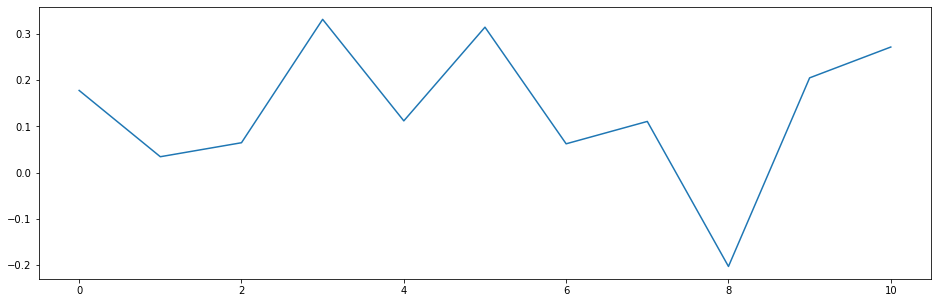

In [38]:
s_mean = sentic.groupby(pd.Grouper(key="date", freq="D"))['sentic'].mean().reset_index()
s_mean.to_excel("results_sentic_day.xlsx")


figure(figsize=(16,5))
plt.plot(s_mean['sentic'])